In [1]:
%matplotlib inline

import matplotlib 
import numpy as np
import pandas as pd
import os, sys, time, pickle, copy
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    

from scipy import optimize

import cv2 

matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=10)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=True)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick', direction="in")
matplotlib.rc('ytick', direction="in")
matplotlib.rc('xtick', top = True)
matplotlib.rc('ytick', right =True )
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(12, 9))



# Chapter 6. 이미지 복원 및 재구성 (Image Restoration & Reconstruction)

# 6.1 이미지 복원

##  이미지 정보의 열화, 왜곡 원인
- 보통 환경적인 요인, 
- 잡음 (noise), 
- 이미지 센서의 열화 (degradation), 
- 화각의 불균형으로 인한 기하학적 왜곡 (distortion)
   
<br>

## 수학적 가정
- 이미지 열화 (degradation)의 원인을 이미지에 작용하는 어떤 선형이고 위치불변인 ‘연산자 (operator)’로 표현 할 수 있음.

<br>

#### 선형성 (Linearity)
행렬에 대한 연산자 $\hat{H}$ 가 두 행렬 $f_1(x,\,y),\,f_2 (x,\,y)$ 와 임의의 스칼라 $a,\,b$ 에 대해 다음을 만족시킬 때 $\hat{H}$ 을 선형연산자라 한다.

$$
\hat{H} [af_1(x,\,y)+bf_2(x,\,y)]= a\hat{H} [f_1(x,\,y)] + b\hat{H}[f_2 (x,\,y)]
$$

<br>

#### 위치불변성 (Position invariance)

연산자 $\hat{H}$ 가 이미지 행렬 $f(x,\,y)$ 에 대해 다음을 만족하면 $\hat{H}$ 를 위치불변 (position -invariant) 라 한다.

$$
g(x,\,y) = \hat{H}[f(x,\,y)] \implies \hat{H}[f(x-a,\,y-b)] = g(x-a,\,y-b)
$$

- 이제 선형이고 위치불변인 연산자를 **LPI** (Linear and Position-Invariant) 연산자라 하자.

<br>

## 역공간에서의 표현
- $f(x,\,y) = \mathfrak{I}^{-1}[F(u,\,v)]$ : 원본 이미지
- $h(x,\,y) = \mathfrak{I}^{-1}[H(u,\,v)]$ : 열화 원인 연산자
- $\eta (x,\,y) = \mathfrak{I}^{-1} [N(u,\,v)]$ : 노이즈 행렬
- $g(x,\,y) = \mathfrak{I}^{-1}[G (u,\,v)]$ : 최종 이미지

라 할 때 실공간과 역공간에서 표현하면 다음과 같은 관계식을 만족한다.

$$
\begin{aligned}
g(x,\,y) &= h(x,\,y) \ast f(x,\,y) + \eta(x,\,y)\\
G(u, v) &= H (u, v)  F (u, v) + N (u, v)
\end{aligned}
$$

<br>



## 노이즈 행렬

#### 노이즈의 원인에 따른 분류 

1. 백색 잡음 (white noise) : 역공간에서 잡음 행렬의 분포가 일정
2. 가우시안 잡음 (Gaussian noise) : 온도 분포의 불균일성, 광량의 불균일성 등으로 인해 전자 회로의 노이즈, 센서의 노이즈 때문에 주로 발생
3. 레일리 잡음 (Rayleigh noise) : 레인지 이미징 (range imaging, High Dynamic Range imaging ,HDRI)에서 주로 발생


 - 레인지 이미징 : 주로 피사체의 광량 분포가 불균일할 때, 그것을 균일하게 만들어 주는 이미징을 의미합니다. 
 
<br> 

#### 많이 사용되는 노이즈 확률 분포

- 가우시안 잡음(Gaussian noise)
- 레일리 잡음 (Rayleigh noise),
- 에를랑 잡음 (Erlang noise or gamma noise), 
- 지수적 잡음 (exponential noise), 
- 균일 잡음 (uniform noise), 
- 임펄스 잡음 (impulse noise) 

<br>
 
#### 가우시안 잡음의 확률분표

$$
p(z) =  \dfrac{1}{\sqrt{2\pi \sigma}} e^{(z - \langle z \rangle)^2/2\sigma^2 }
$$

여기서 $\langle z \rangle, \, \sigma^2$ 는 가우시안 잡음의 평균과 분산

<br>

#### 레일리 잡음의 확률분포

$$
p(z) = \left\{\begin{array}{ll} \dfrac{2}{b}(z-a)^2 e^{-(z-a)^2/b} \qquad & \text{for }z \ge a \\ 0 & \text{for }z<a \end{array} \right.
$$ 

이 때, $z$ 는 픽셀 값, $a$ 는 픽셀값의 문턱 값이다. 이 확률분포의 평균과 분산은 다음과 같다.

$$
\langle z \rangle = a+ \left(\dfrac{\pi b}{4}\right)^{1/2}, \qquad \sigma^2 = \dfrac{b(4-\pi)}{4}
$$

<br>

#### 에를랑 잡음의 확률 분포

$$
p(z) = \left\{\begin{array}{ll}
\dfrac{a^bz^{b-1}}{(b-1)!}e^{-az} \qquad & \text{for }z \ge 0 \\ 
0 & \text{for } z<0 
\end{array} \right.
$$

이 확률분포의 평균과 분산은 다음과 같다.

$$
\langle z \rangle = \dfrac{b}{a},\qquad \sigma^2 = \dfrac{b}{a^2}
$$

<br>


#### 지수적 잡음

$$
p(z) = \left\{\begin{array}{ll}
ae^{-az} \qquad & \text{for }z \ge 0 \\ 
0 & \text{for } z<0 
\end{array} \right.
$$

이 확률분포의 평균과 분산은 다음과 같다.

$$
\langle z \rangle = \dfrac{1}{a},\qquad \sigma^2 = \dfrac{1}{a^2}
$$

<br>


#### 균일 잡음

$$
p(z) = \left\{\begin{array}{ll}
\dfrac{1}{b-a} \qquad & \text{for } a\le z \le  b \\ 
0 & \text{otherwise }
\end{array} \right.
$$

이 확률분포의 평균과 분산은 다음과 같다.

$$
\langle z \rangle = \dfrac{a+b}{2},\qquad \sigma^2 = \dfrac{(b-a)^2}{12}
$$

<br>



#### 임펄스 잡음

$$
p(z) = \left\{\begin{array}{ll} P_a \qquad & \text{for }z=a \\
P_b & \text{for } z=b \\ 0 &\text{otherwise} \end{array} \right.
$$

- Salt-and-Pepper (S&P) 노이즈가 대표적

<br>


## 임펄스 신호 와 LPI 연산자

임펄스 신호 $\delta (x-\alpha,\,y-\beta)$ 를 LPI 연산자 $\hat{H}$ 에 적용한 것을 $h(x,\,\alpha,\,y,\,\beta)$ 라 하자. 즉

$$
h(x,\,\alpha,\,y,\,\beta) = \hat{H}[\delta (x-\alpha,\,y-\beta)]
$$

이다. $\delta$ 함수의 성질에 의해 다음이 성립함을 안다.

$$
f(x,\,y) = \iint f(\alpha,\, \beta) \,\delta(x-\alpha,\, y-\beta)\, d\alpha\,d\beta
$$

이제 이미지 $f(x,\,y)$ 에 $\hat{H}$ 를 적용하면,

$$
\begin{aligned}
g(x,\,y) &= \hat{H}[f(x,\,y)] \\
&= \hat{H} \left[ \iint f(\alpha,\, \beta) \,\delta(x-\alpha,\, y-\beta)\, d\alpha\,d\beta \right] \\
&= \iint \hat{H} [f(\alpha,\, \beta) \,\delta(x-\alpha,\, y-\beta)] \, d\alpha\,d\beta \\
&= \iint f(\alpha,\, \beta) \,\hat{H} [\delta(x-\alpha,\, y-\beta)] \, d\alpha\,d\beta \\
&= \iint f(\alpha,\, \beta) \,h(x,\,\alpha,\, y,\,\beta)] \, d\alpha\,d\beta \\
&= \iint f(\alpha,\,\beta) \,h(x-\alpha,\, y-\beta)\, d\alpha\, d\beta\\
&= h (x,\,y) * f(x,\,y)
\end{aligned}
$$

위 식에서 적분 내에서 $h(x,\,\alpha,\, y,\,\beta) \to h(x-\alpha,\, y-\beta)$ 로 변환되는 데는 Fredholm integral of the first kind 를 사용하였다. $h(x-\alpha,\, y-\beta) = h(x,\,\alpha,\,y,\,\beta)$ 를 **점 확산 함수 (point spread function, PSF)** 이라 한다. 

<br>

푸리에 변환의 성질에 의해 역공간에서는

$$
G(u,\,v) = H(u,\,v) F(u,\,v)
$$

가 성립한다. 


> 이를 조금 더 알기 쉽게 설명하자면 이렇습니다. 어떤 이미지가 열화된 것처럼 보인다면, 그 원인에 해당하는 특정한 LPI(라고가정할수있는) 열화연산자 $\hat{H}$가 있을것입니다.그리고 또 그것에 해당하는 고유의 점확산함수 $h(x,y)$가 있을 것이고요. 점,즉 픽셀값이 확산되는 경향 (강도, 방향 등)이 바로 이미지가 열화되는 정도를 결정하는데, 그 정도는 점 확산 함수와 원본 이미지 행렬의 합성곱으로 결정됩니다. 다시 말해, 이미지에 있는 모든 픽셀 (즉, ‘점’)이 얼마나 퍼질 수 있는지 그래서 얼마나 왜곡이 되고 열화되는지가 결과적으로 LPI 연산자의 함수 특성에 의해 결정되는 것입니다.

> 이제 이미지의 열화를 야기한 연산자에 대한 사전 정보가 없을 때, 연산자 정보를 어떻게 추정할 수 있을지 생각해 봅시다. 열화과정은 이미지를 관찰하거나, 실험해 보거나, 수학적으로 모델링함으로써 추정할 수 있습니다. 

## 열화 연산자 모델
<br>
### 공기의 흔들림 (가우시안) 에 의한 이미지 열화

흔들림 연산자는 수학적으로 다음과 같은 식이 많이 쓰인다.
$$
H(u,\,v) = e^{-k(u^2+v^2)^{5/6}}
$$


### 피사체의 흔들림에 의한 열화 (motion blur)

피사체가 $T$ 의 시간동안 카메라에 노출되어 $x,\,y$ 방향으로 각각 $x_0(t),\, y_0(t)$ 만큼 움직이는 이미지는 다음과 같이 표현된다.

$$
g(x,\,y) = \int_0^T f[x-x_0(t),\, y-y_0(t)]\, dt
$$

이에 대한 푸리에 변환은 다음과 같다.

$$
\begin{aligned}
G(u,\,v) &= \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} g(x,\,y)\, e^{-2i\pi (ux+vy)}\,dx\,dy \\
&=\int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \left[ \int_0^Tf(x,\,y) e^{-2i\pi(ux+vy)}e^{-2i\pi(ux_0(t)+vy_0(t))}\,\, dt\right] dx\,dy \\
&=F(u,\,v) \int_0^T e^{-2i\pi(ux_0(t)+vy_0(t))}\, dt = F(u,\,v) H(u,\,v)\qquad \text{where }H(u,\,v) =\int_0^T e^{-2i\pi(ux_0(t)+vy_0(t))}\, dt
\end{aligned}
$$

즉 피사체 움직임에 의한 열화 LPI 연산자는 위 식의 $H(u,\,v)$ 이다.




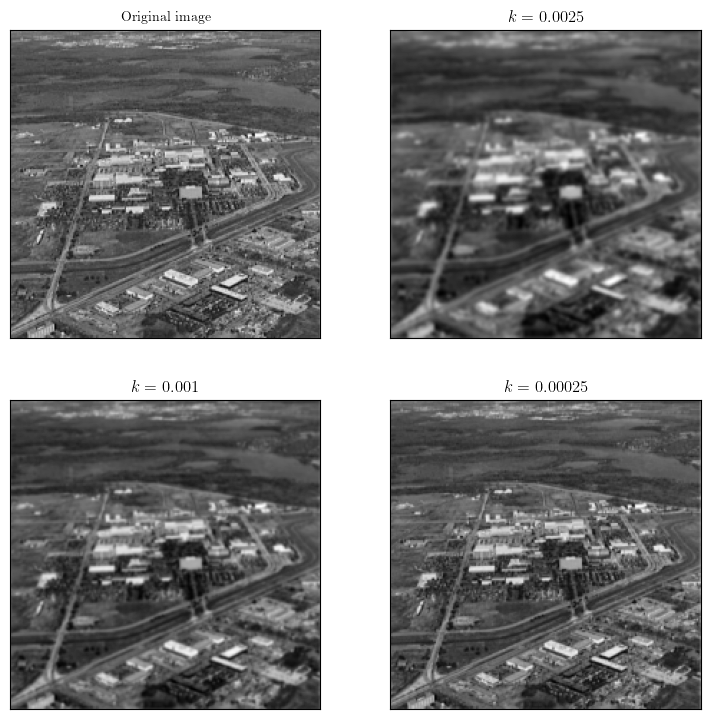

In [290]:
def make_at_operator(shape, k=0.1):
    """
    atmospheric turbulence 
    
    $H(u,v)= \exp (-k(u^2+v^2)^5/6)$
    
    size : kernel size
    k : k value in the formula
    
    """
    c1, c2 = (shape[0]-1)>>1, (shape[1]-1)>>1
    u, v = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    ff = np.exp(-k*((u-c1)**2+(v-c2)**2)**(5/6.))
    return ff/ff.sum()


fig1 = plt.figure(figsize=(9,9), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4 = fig1.add_subplot(221), fig1.add_subplot(222), fig1.add_subplot(223), \
                    fig1.add_subplot(224)


img1=cv2.cvtColor(cv2.imread("./img_psf_01.jpg"), cv2.COLOR_BGR2GRAY)[::3,::3]
ax1.imshow(img1, cmap='gray')
ax1.set_title("Original image", size=10)

imgfft = np.fft.fftshift(np.fft.fft2(img1))


H2 = make_at_operator(img1.shape, 0.0025)
img2=np.fft.ifft2(H2.T*imgfft)
ax2.imshow(np.abs(img2), cmap='gray')
ax2.set_title("$k=0.0025$")

H3 = make_at_operator(img1.shape, 0.001)
img3=np.fft.ifft2(H3.T*imgfft)
ax3.imshow(np.abs(img3), cmap='gray')
ax3.set_title("$k=0.001$")


H4 = make_at_operator(img1.shape, 0.00025)
img4=np.fft.ifft2(H4.T*imgfft)
ax4.imshow(np.abs(img4), cmap='gray')
ax4.set_title("$k=0.00025$")

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig1.tight_layout()
plt.show()

## Motion Bluring

카메라에 $T$ 의 시간만큼 노출되며 이 시간동안의 피사체의 움직임을 $x_0(t),\,y_0(t)$ 로 기술 할 수 있다고 하자. $f(x,\,y)$ 를 정지상태의 이상적인 피사체의 이미지라 하면, 이 때 피사체의 이미지 $g(x,\,y)$ 는 다음과 같이 기술된다.

$$
g(x,\,y) = \int_0^T f(x-x_0(t),\, y-y_0(t))\, dt
$$
이를 푸리에 변환하면,

$$
\begin{aligned}
G(u,\,v) &= \mathfrak{I}[g(x\,y)] = \iint g(x,\,y) e^{-2i\pi (ux+vy)}\,dxdy\\
&= \iint \left[ \int_0^T f(x-x_0(t),\, y-y_0(t))\, dt\right] e^{-2i\pi (ux+vy)}\,dxdy\\
&= \int_0^T \left[\iint f(x-x_0(t),\, y-y_0(t)  e^{-2i\pi (ux+vy)}\,dxdy\right] \, dt\\
&= \int_0^T F(u,\,v)  e^{-2i\pi (ux_0(t)+vy_0(t))}\,dxdy \\
&= \int F(u,\,v) H(u,\,v),\qquad \text{where}\quad H(u,\,v) = \int_0^T e^{-2i\pi (ux_0(t)+vy_0(t))}\,dxdy 
\end{aligned}
$$

즉 피사체의 열화 LPI 연산자 $H(u,\,v) = \displaystyle \int_0^T e^{-2i\pi (ux_0(t)+vy_0(t))}\,dxdy $ 를 알 수 있다.
만약 피사체가 속도 $(a/T,\, b/T)$ 의 단순선형등속은동을 한다면, $x_0(t) = at/T,\, y_0(t) =bt/T$ 이므로, 

$$
H(u,\,v) = \int_0^T e^{-2i\pi(au+bv)t/T}\, dt=\dfrac{T}{au+bv} \sin \left[\pi(au+bv)\right]e^{-2i\pi(au+bv)}
$$

가 된다. 이로부터,

$$
f(x,\,y) = \mathfrak{I}^{-1}[F(u,\,v)] = \mathfrak{I}^{-1}\left[G(u,\,v)/H(u,\,v)\right]
$$

의 관계를 통해 $f(x,\,y)$ 를 복원 할 수 있다.

<br>


### Inverse filtering 을 통한 motion blur 복원

피사체의 움직임을 단순한 선형 등속 움직임 즉, $x_0(t) = \dfrac{at}{T},\, y_0(t) = \dfrac{bt}{T}$ 라고 표현 할 수 있다고 가정하면,

$$
H(u,\,v) = \int_0^T e^{-2i\pi (ux_0(t)+vy_0(t))} \, dt = \dfrac{T}{\pi (ua+vb)} \sin (\pi (ua+vb)) e^{-i\pi (ua+bv)}
$$

이다. 

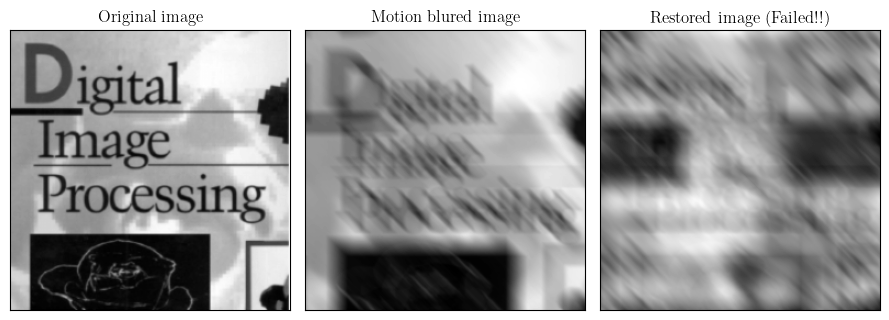

In [466]:
fig1 = plt.figure(figsize=(9,9), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3 = fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)

img0=cv2.cvtColor(cv2.imread("./img_motion_01.png"), cv2.COLOR_BGR2GRAY)
img1 = cv2.resize(img0, (255, 255))
ax1.imshow(img1, cmap='gray')
ax1.set_title("Original image")


motionsize = 20
mker = np.zeros(img1.shape)
center = (ksize-1)>>1
for i in range(center-motionsize, center ):
    mker[i, i]=1
mker = mker/motionsize


    
img2 = cv2.filter2D(img1,-1, mker)
ax2.imshow(img2, cmap='gray')
ax2.set_title("Motion blured image")

imgfft = np.fft.fftshift(np.fft.fft2(img2))

kerfft = np.fft.fftshift(np.fft.fft2(mker))

abker = np.abs(kerfft)

kerfft[np.abs(kerfft)<0.6]=1



invimg = np.fft.ifft2(imgfft/kerfft)
ax3.imshow(np.abs(invimg), cmap='gray')
ax3.set_title("Restored image (Failed!!)")

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig1.tight_layout()
plt.show()

### 노이즈가 있는 이미지의 복원

- 사실 노이즈를 처리한 후 열화 연산자를 추정하여 이미지를 복원하는 것은 이상적인 시나리오에 가깝다. 왜냐하면 노이즈의 종류와 열화 연산자의 정체를 미리 알고 있어야만 이러한 처리가 깔끔하게 이루어질 것이기 때문이다. 노이즈의 정체를 모르는 상황이라면 노이즈만 따로 전처리 (pre-treatment)하기 어려울 것이다. 

- 노이즈가 없는 이미지 $f(x,y)$ 와 노이즈 $n(x,y)$ 를 생각하자. 이미지는 $g(x,\,y)= f(x,\,y)+n(x,\,y)$ 가 될 것이다. 이 때 

$$
\begin{aligned}
F(u,v) &= \mathfrak{I} [f(x,y)]\\
N(u,v) &= \mathfrak{I} [n(x,y)]\\
G(u,v) &= \mathfrak{I}[g(x,y)] = F(u,v)+N(u,v)
\end{aligned}
$$

라 하자

- 노이즈를 처리하지 않은 상황이라면 $H$ 연산에 대해 처리된 결과는 $F(u,v)$ 가 아닌 $\hat{F}(u,\,v) = F(u,v) +\dfrac{N(u,v)}{H(u,v)}=\dfrac{G(u,v)}{H(u,v)}$ 가 될 것이다.
- $\hat{F}(u,v)$ 에서 $H(u,v)$ 가 매우 작거나 어떤 노이즈에 의해 $N(u,v)$ 가 매우 크다면 결과적으로 $F(u,v)$ 보다 $\dfrac{N(u,v)}{H(u,v)}$ 가 더 지배적일 수 있다. 이를 막기 위한 방밥중에는 전에 배웠던 버터워스 필터링, 위너 필터링이 있다.

### 계수조절 비너 필터링 (Parametric Wiener filtering)


### 제한된 최소자승법 필터링 (Constrained least squarefiltering, CLSF)


### 기하평균 필터링 (Geometric mean filtering)

# 6.2 이미지 재구성 (Image Reconstruction)

<br>

#### 이미지 복원과 이미지 재구성

- 이미지 복원은 열화된 이미지를 최대한 품질을 개선시키는 방법 에 초점을 맞췄다면, 이미지 재구성은 여러 장의 이미지 혹은 여러 방향에서 찍은 이미 지를 하나의 이미지로 재구축하는 과정에 초점을 맞춥니다.

- 이미지 재구성은 CT (computer tomography) 같은 첨단 의료영상정보 처리에 활발하게 활용되는 매우 중요 한 이미지 처리 방법입니다.

<br>

### 후방 사영법 (Backprojection)

- 피사체 앞에서 빔을 나란히 쏜 후, 피사체를 통과한 빔의 강도를 후 방에서 모아서 하나의 이미지로 만드는 방법.
- 피사체의 부분마다 빔에 대한 투과도 (transmission coefficient)나 흡광도 (absorption coefficient)가 다르다는 것에 착안한 방법.
- 예를 들어 암세포는 다른 세포에 비해 X-ray를 더 잘 흡수하는 경향이 있는데, 그 세포를 향해 X-ray를 쏜다면, 세포 뒤에 건판에는 서로 다른 강도의 X-ray 신호가 나타날 것이다. 그리고 그 세포를 향해 쏘는 X-ray의 방향을 계속 돌려 보면, 그 세포의 상대적 위치에 대해 모든 정보를 얻을 수 있을 것이다.
- 후방 사영법은 단순하지만 후방 사영하는 각도 단위가 작아질수록 (즉, 해상력 이 높아질수록) 재구축되는 이미지가 더 정교해진다는 장점이 있다. 
- 그럼에도 불구하고, 후방 사영법만으로는 피사체의 디테일을 전부 다 살리기 어려운데, 그 이유는 후방 사영법의 특징 상, 사영된 이미지의 겹침 과정에서 피사체의 경계 부분이 블러링되는 것을 피할 수 없기 때문. 이 때문에, 후방 사영법을 필터링하는 알고리듬이 필요하다.

<br>

### 라돈 변환 (Radon Transform)

python 에서는 opencv 에서는 제공하지 않는 것 같고, skimage 에서 제공한다. 역변환인 
~~~python
from skimage.transform import radon
# get sinogram by radon transform
sinogram = radon(img1, theta)

# reconstruct by iradon
reconstruction_img = iradon(sinogram, theta=theta, filter='ramp')
~~~
으로 사용 할 수 있다.

아래 radon transform 은 아래 사이트를 참고하라

https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html

In [515]:
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon

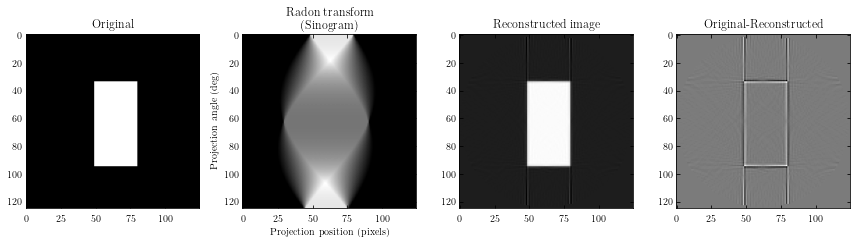

In [533]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))

x, y = np.arange(125), np.arange(125)
X, Y = np.meshgrid(x, y)
img1 = np.ones(X.shape)
img1[(np.abs(Y-64)>30)]=0
img1[(np.abs(X-64)>15)]=0

theta = np.linspace(0., 180., max(img1.shape), endpoint=False)
sinogram = radon(img1, theta=theta)

ax1.imshow(img1, cmap='gray')
ax1.set_title("Original")

ax2.imshow(sinogram.T, cmap='gray')
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_ylabel("Projection angle (deg)")
ax2.set_xlabel("Projection position (pixels)")

reconstruction_img = iradon(sinogram, theta=theta, filter='ramp')
ax3.imshow(reconstruction_img, cmap='gray')
ax3.set_title("Reconstructed image")

ax4.imshow(img1-reconstruction_img, cmap='gray')
ax4.set_title("Original-Reconstructed")
plt.tight_layout()
plt.show()


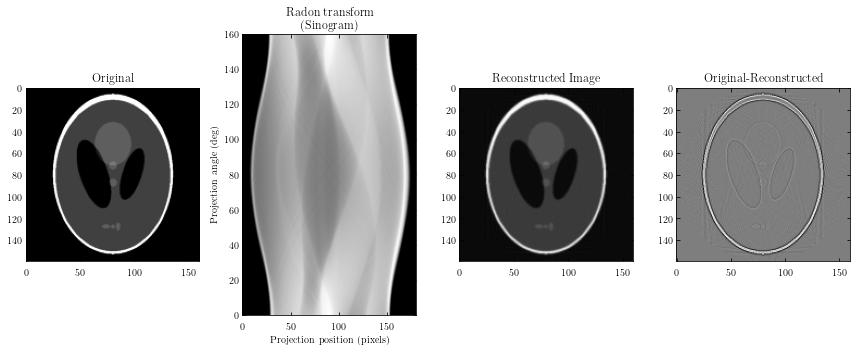

In [535]:

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_ylabel("Projection angle (deg)")
ax2.set_xlabel("Projection position (pixels)")
ax2.imshow(sinogram.T, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')


reconstruction_img = iradon(sinogram, theta=theta, filter='ramp')
ax3.imshow(reconstruction_img, cmap='gray')
ax3.set_title("Reconstructed Image")

ax4.imshow(image-reconstruction_img, cmap='gray')
ax4.set_title("Original-Reconstructed")
fig.tight_layout()
plt.show()